In [1]:
!pip install barbar
!pip install wandb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from barbar import Bar
import csv
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

import wandb
from kaggle_secrets import UserSecretsClient

# System
import os
import time

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

using device: cuda


In [3]:
user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_key = user_secrets.get_secret("wandb_key") 

wandb.login(key=wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Neural network parameters:
classes_count = 14       # dimension of the output
# Training settings: batch size, maximum number of epochs
batch_size = 32
max_epochs = 3
com_round = 3
fraction = 1.0
epoch = 3
num_clients = 5
policy = "ones"
lr = 0.0001
eps = 1e-08
betas = (0.9, 0.999)
weight_decay = 0
train_ratio = 1
num_workers = 2

# Parameters related to image transforms: size of the down-scaled image, cropped image
image_resize = (224, 224)
image_crop = 224
# start a new wandb run to track this script
wandb.init(
    project="Radiance.AI",
    
    config={
        "model": {
            "weights": "DEFAULT",
            "architecture": "Resnet101",
        },
        "optimizer": {
            "learning_rate": lr,
            "eps": eps,
            "betas": betas,
            "weight_decay": weight_decay
        },
        "train": {
            "max_epochs": max_epochs,
            "epochs": epoch,
            "num_clients": num_clients,
            "com_round": com_round,
            "batch_size": batch_size,
            "fraction": fraction,
            "train_ratio": train_ratio,
            "data_loader_num_workers": num_workers
        },
        "dataset": {
            "name": "CheXpert",
            "classes_count": classes_count,
            "policy": policy
        } 
    }
)

wandb: Currently logged in as: ab-zitouni (dee-pa). Use `wandb login --relogin` to force relogin


## Model

In [5]:
!rm -r /kaggle/working/chexpert
!rm /kaggle/working/*.csv

rm: cannot remove '/kaggle/working/chexpert': No such file or directory
rm: cannot remove '/kaggle/working/*.csv': No such file or directory


In [6]:
working_dir = '/kaggle/working/chexpert/'
os.makedirs(f"{working_dir}chexpert")

In [7]:
import re
import pandas as pd

# Define the old and new file path patterns
old_pattern = r'^CheXpert-v1\.0-small\/'
new_pattern = '../input/chexpert/'

# Compile the regular expression patterns
old_regex = re.compile(old_pattern)
#new_regex = re.compile(new_pattern)

# Loop through the CSV files
for file_name in ['train.csv', 'valid.csv']:
    # Read in the file
    df = pd.read_csv(f'/kaggle/input/chexpert/{file_name}')
    
    # Replace the file path column using regex
    df['Path'] = df['Path'].str.replace(old_regex, new_pattern, regex=True)
    
    # Save the updated file
    df.to_csv(f'/kaggle/working/{file_name}', index=False)



In [8]:
pd.read_csv(f'/kaggle/working/valid.csv')

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,../input/chexpert/valid/patient64541/study1/vi...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,../input/chexpert/valid/patient64542/study1/vi...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,../input/chexpert/valid/patient64542/study1/vi...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,../input/chexpert/valid/patient64543/study1/vi...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,../input/chexpert/valid/patient64544/study1/vi...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,../input/chexpert/valid/patient64736/study1/vi...,Female,57,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
230,../input/chexpert/valid/patient64737/study1/vi...,Male,65,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
231,../input/chexpert/valid/patient64738/study1/vi...,Male,71,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
232,../input/chexpert/valid/patient64739/study1/vi...,Female,45,Frontal,AP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
working_dir = '/kaggle/working/chexpert/'

###################
## Preprocessing ##
###################
# Each file contains pairs (path to image, output vector)
train_csv_path = '/kaggle/working/train.csv'
# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
train_data = pd.read_csv(train_csv_path)
train_data = train_data[train_data['Path'].str.contains("frontal")] # use only frontal images
train_data = train_data[500:]
train_data.to_csv(f'{working_dir}train_mod.csv', index = False)
print("Train data length:", len(train_data))

valid_csv_path = '/kaggle/working/valid.csv'
valid_data = pd.read_csv(valid_csv_path)
valid_data = valid_data[valid_data['Path'].str.contains("frontal")] # use only frontal images
valid_data.to_csv(f'{working_dir}valid_mod.csv', index = False)
print("Valid data length:", len(valid_data))

test_data = train_data.head(500) # use first 500 training data as test data (obs ratio is almost same!)
test_data.to_csv(f'{working_dir}test_mod.csv', index = False)
print("Test data length:", len(test_data))

train_frontal_path = f'{working_dir}train_mod.csv'
valid_frontal_path = f'{working_dir}valid_mod.csv'
test_frontal_path = f'{working_dir}test_mod.csv'

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


Train data length: 190527
Valid data length: 202
Test data length: 500


In [10]:
wandb.log({"Train data length": len(train_data),
          "Valid data length": len(valid_data),
           "Test data length": len(test_data)
          })

In [11]:
######################
## Create a Dataset ##
######################
from torch.utils.data import Dataset
import csv
from sklearn.metrics import roc_auc_score

class CheXpertDataSet(Dataset):
    def __init__(self, data_path, transform = None, policy ="ones"):
        """
        data_PATH: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels.
        """
        image_names = []
        labels = []

        with open(data_path, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None) # skip the header
            for line in csvReader:
                image_name = line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                image_names.append('./' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

############################
## Create CheXpertTrainer ##
############################

use_gpu = torch.cuda.is_available()

class CheXpertTrainer():

    def train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, checkpoint, client, nround):
        optimizer = optim.Adam(model.parameters(), lr = 0.0001, # setting optimizer & scheduler
                               betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0) 
        loss = torch.nn.BCELoss() # setting loss function
        
        if checkpoint != None and use_gpu: # loading checkpoint
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])
            
        # Train the network
        lossMIN = 100000
        train_start = []
        train_end = []
        for epochID in range(0, trMaxEpoch):
            train_start.append(time.time()) # training starts
            losst = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            train_end.append(time.time()) # training ends
            lossv = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)
            print("Training loss: {:.3f},".format(losst), "Valid loss: {:.3f}".format(lossv))
            
            if lossv < lossMIN:
                best_history = {'best_loss_epoch': epochID + 1, 'best_state_dict': model.state_dict(), 
                            'best_loss': lossMIN, 'best_optim_state' : optimizer.state_dict()}
                lossMIN = lossv
                torch.save(best_history, 'm-epoch_FL' + str(epochID + 1) + '.pth.tar')
                print('Epoch ' + str(epochID + 1) + ' [save] loss = ' + str(lossv))
            else:
                print('Epoch ' + str(epochID + 1) + ' [----] loss = ' + str(lossv))
                
            history = {f'epoch-r{nround}-c{client}': epochID + 1, f'train_loss-r{nround}-c{client}': losst, 
                            f'valid_loss-r{nround}-c{client}': lossv}
            wandb.log(history)
        train_time = np.array(train_end) - np.array(train_start)
        wandb.log({f'train_time-r{nround}-c{client}': train_time})
        print("Training time for each epoch: {} seconds".format(train_time.round(0)))
        params = model.state_dict()
        return params
       
        
    def epochTrain(model, dataLoaderTrain, optimizer, epochMax, classCount, loss):
        losstrain = 0
        model.train()

        for batchID, (varInput, target) in enumerate(Bar(dataLoaderTrain)):
            
            varTarget = target.cuda(non_blocking = True)
            varOutput = model(varInput)
            lossvalue = loss(varOutput, varTarget)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            losstrain += lossvalue.item()
            
        return losstrain / len(dataLoaderTrain)
    
    
    def epochVal(model, dataLoaderVal, optimizer, epochMax, classCount, loss):
        model.eval()
        lossVal = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):
                
                target = target.cuda(non_blocking = True)
                varOutput = model(varInput)
                
                lossVal += loss(varOutput, target)
                
        return lossVal / len(dataLoaderVal)

    
    def computeAUROC(dataGT, dataPRED, classCount):
        # Computes area under ROC curve 
        # dataGT: ground truth data
        # dataPRED: predicted data
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC
    
    
    def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):
        cudnn.benchmark = True
        
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            for i, (input, target) in enumerate(dataLoaderTest):

                target = target.cuda()
                outGT = torch.cat((outGT, target), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
            
                out = model(varInput)
                outPRED = torch.cat((outPRED, out), 0)
        aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        print('AUROC mean', aurocMean)
        wandb.log({"AUROC mean": aurocMean})
        for i in range (0, len(aurocIndividual)):
            print(class_names[i], ' ', aurocIndividual[i])
            wandb.log({f"{class_names[i]} AUROC": aurocIndividual[i]})
        
        return outGT, outPRED

##################
## Define Model ##
##################
class ResNet101(nn.Module):
    
    def __init__(self, out_size):
        super(ResNet101, self).__init__()
        self.resnet101 = torchvision.models.resnet101(weights="DEFAULT")
        num_ftrs = self.resnet101.fc.in_features
        self.resnet101.fc = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.resnet101(x)
        return x



###############################
## Define Ensembles Function ##
###############################
def EnsemAgg(EnsemResult, dataLoader, nnClassCount, class_names):
    outGT = torch.FloatTensor().cuda()
    outPRED = torch.FloatTensor().cuda()
    with torch.no_grad():
        for i, (input, target) in enumerate(dataLoader):
            target = target.cuda()
            outGT = torch.cat((outGT, target), 0).cuda()
            
            bs, c, h, w = input.size()
            varInput = input.view(-1, c, h, w)

            out = torch.tensor([EnsemResult[i]]).cuda()
            outPRED = torch.cat((outPRED, out), 0)
    aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
    aurocMean = np.array(aurocIndividual).mean()
    print('<<< Ensembles Test Results: AUROC >>>')
    print('MEAN', ': {:.4f}'.format(aurocMean))
    for i in range (0, len(aurocIndividual)):
        print(class_names[i], ': {:.4f}'.format(aurocIndividual[i]))
    print('')

    return outGT, outPRED, aurocMean, aurocIndividual

In [12]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # mean of ImageNet dataset(for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]   # std of ImageNet dataset(for normalization)


# Tranform data
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
transform_list = [transforms.Resize(image_resize), transforms.ToTensor()]

# transformList.append(transforms.RandomResizedCrop(imgtransCrop))
# transformList.append(transforms.RandomHorizontalFlip())
# transformList.append(normalize)
transform_sequence = transforms.Compose(transform_list)

# Load dataset
train_dataset = CheXpertDataSet(train_frontal_path, transform_sequence, policy =policy)
print("Train data length:", len(train_dataset))

valid_dataset = CheXpertDataSet(valid_frontal_path, transform_sequence)
print("Valid data length:", len(valid_dataset))

test_dataset = CheXpertDataSet(test_frontal_path, transform_sequence, policy =policy)
print("Test data length:", len(test_dataset))

Train data length: 190527
Valid data length: 202
Test data length: 500


In [13]:
# Divide datasetTrain_real
train_dataset_1, train_dataset_2, train_dataset_3, train_dataset_4, train_dataset_5 = random_split(train_dataset,
                                                                                                   [38106, 38106, 38105, 38105, 38105])


# Define 5 DataLoaders
train_dataloader_1 = DataLoader(dataset = train_dataset_1, batch_size = batch_size,
                                shuffle = True, num_workers = num_workers, pin_memory = True)
train_dataloader_2 = DataLoader(dataset = train_dataset_2, batch_size = batch_size,
                                shuffle = True, num_workers = num_workers, pin_memory = True)
train_dataloader_3 = DataLoader(dataset = train_dataset_3, batch_size = batch_size,
                                shuffle = True, num_workers = num_workers, pin_memory = True)
train_dataloader_4 = DataLoader(dataset = train_dataset_4, batch_size = batch_size,
                                shuffle = True, num_workers = num_workers, pin_memory = True)
train_dataloader_5 = DataLoader(dataset = train_dataset_5, batch_size = batch_size,
                                shuffle = True, num_workers = num_workers, pin_memory = True)

# Define Valid and Test DataLoaders
valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = batch_size,
                              shuffle = False, num_workers = num_workers, pin_memory = True)
test_dataloader = DataLoader(dataset = test_dataset, num_workers = num_workers, pin_memory = True)


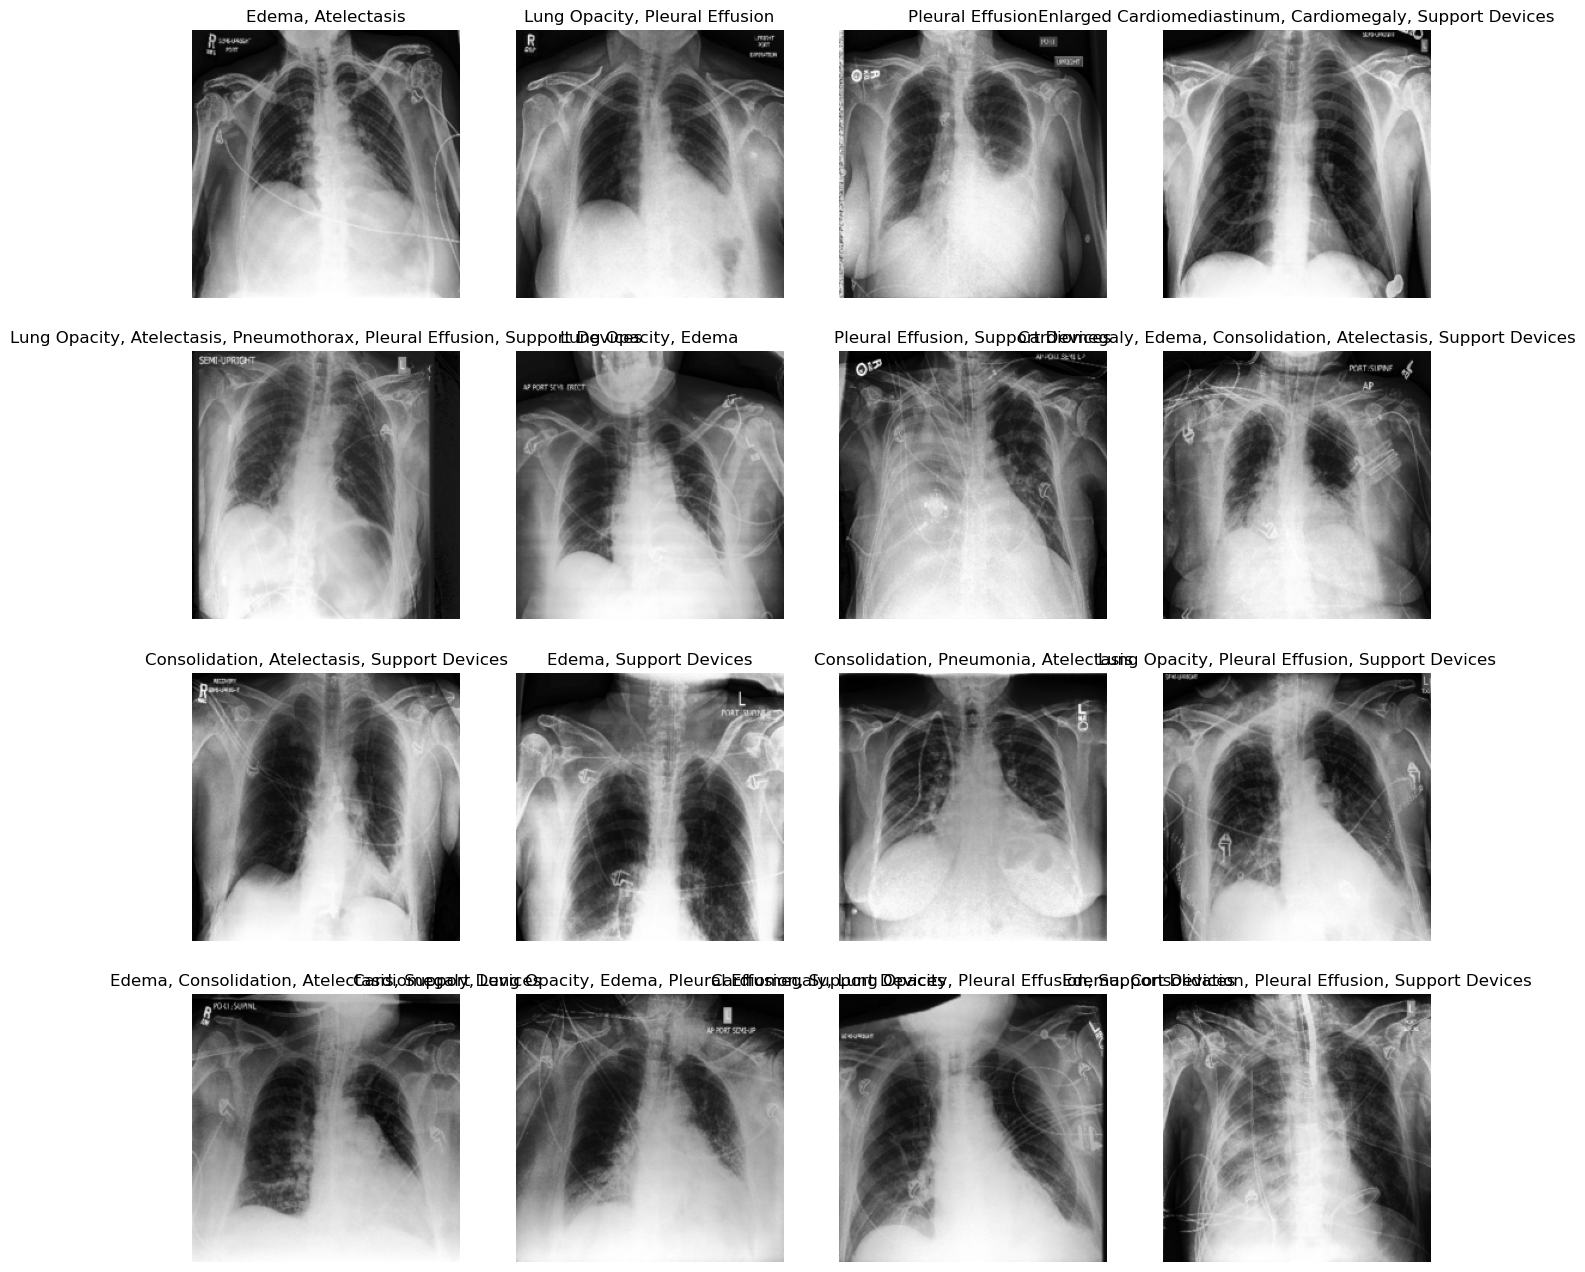

In [14]:
t_x, t_y = next(iter(train_dataloader_1))

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x.permute(1,2,0))
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(class_names, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [15]:
os.makedirs("./model")

In [16]:
train_datasets = [train_dataset_1, train_dataset_2, train_dataset_3, train_dataset_4, train_dataset_5]
train_dataloaders = [train_dataloader_1, train_dataloader_2, train_dataloader_3, train_dataloader_4, train_dataloader_5]

model = ResNet101(classes_count).cuda() # Step 0: Initialize global model and load the model
model = torch.nn.DataParallel(model).cuda()

for i in range(com_round):
    print(f"[[[ Round {i + 1} Start ]]]")
    params = [None] * num_clients
    sel_clients = sorted(random.sample(range(num_clients), 
                                       round(num_clients*fraction))) # Step 1: select random fraction of clients
    print("The number of clients:", len(sel_clients))
    for j in sel_clients: # Step 2: send weights to clients
        print(f"<< Client {j + 1} Training Start >>")
        train_valid_start = time.time()
        params[j] = CheXpertTrainer.train(model, train_dataloaders[j], valid_dataloader,  # Step 3: Perform local computations
                                          classes_count, trMaxEpoch = epoch, checkpoint = None, client=j + 1, nround=i + 1)
        train_valid_end = time.time()
        client_time = round(train_valid_end - train_valid_start)
        print(f"<< Client {j + 1} Training End: {client_time} seconds elapsed >>")
        
    fidx = [idx for idx in range(len(params)) if params[idx] is not None][0]
    lidx = [idx for idx in range(len(params)) if params[idx] is not None][-1]
    for key in params[fidx]: # Step 4: return updates to server
        weights, weightn = [], []
        for k in sel_clients:
            weights.append(params[k][key] * len(train_dataloaders[k]))
            weightn.append(len(train_dataloaders[k]))
        params[lidx][key] = sum(weights) / sum(weightn) # weighted averaging model weights

    model = ResNet101(classes_count).cuda()
    model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(params[lidx]) # Step 5: server updates global state
    print(f"[[[ Round {i + 1} End ]]]")
    
print("Global model trained")

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

[[[ Round 1 Start ]]]
The number of clients: 5
<< Client 1 Training Start >>
38106/38106: [===============================>] - ETA 11.7s
Training loss: 0.381, Valid loss: 0.375
Epoch 1 [save] loss = tensor(0.3749, device='cuda:0')
38106/38106: [===============================>] - ETA 0.8s
Training loss: 0.345, Valid loss: 0.370
Epoch 2 [save] loss = tensor(0.3699, device='cuda:0')
38106/38106: [===============================>] - ETA 0.7s
Training loss: 0.312, Valid loss: 0.379
Epoch 3 [----] loss = tensor(0.3792, device='cuda:0')
Training time for each epoch: [488. 474. 475.] seconds
<< Client 1 Training End: 1443 seconds elapsed >>
<< Client 2 Training Start >>
38106/38106: [===============================>] - ETA 0.9s
Training loss: 0.352, Valid loss: 0.371
Epoch 1 [save] loss = tensor(0.3711, device='cuda:0')
38106/38106: [===============================>] - ETA 0.8s
Training loss: 0.319, Valid loss: 0.368
Epoch 2 [save] loss = tensor(0.3680, device='cuda:0')
38106/38106: [========

In [17]:
print("hh")

hh


In [18]:
out_ground_table, predictions = CheXpertTrainer.test(model, test_dataloader, classes_count, None, class_names)

AUROC mean 0.9549811351134446
No Finding   0.9795751633986929
Enlarged Cardiomediastinum   0.9513879103846696
Cardiomegaly   0.9732621699669967
Lung Opacity   0.9320459905660378
Lung Lesion   0.9716001298279779
Edema   0.9580669852500052
Consolidation   0.9384024339933993
Pneumonia   0.9358910479986713
Atelectasis   0.9365670898184499
Pneumothorax   0.9856595937966388
Pleural Effusion   0.98135
Pleural Other   0.8674774917074712
Fracture   0.9725618848792126
Support Devices   0.985888


In [19]:
torch.save(model.state_dict(), "Resnet101-CheXpert14-w.pth")

In [20]:
model = model.load_state_dict(torch.load("/kaggle/working/weights101.pth"))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/weights101.pth'

In [ ]:
epoch_loss = 0
epoch_acc = 0
my_table = wandb.Table()
model.eval()

with torch.no_grad():
    outGT = torch.FloatTensor().cuda()
    outPRED = torch.FloatTensor().cuda()
    ts_x, ts_y = next(iter(test_dataloader))

    ts_y = ts_y.cuda()
    outGT = torch.cat((outGT, target), 0).cuda()

    #bs, c, h, w = ts_x.size()
    varInput = ts_x.view(-1, c, h, w).cuda()

    out = model(varInput)
    outPRED = torch.cat((outPRED, out), 0)
    #print(out > 0.5, target)
    my_table.add_column("image", [c_x for c_x in ts_x])
    my_table.add_column("label", [[n_class for n_class, n_score in zip(class_names, c_y) 
                                 if n_score>0.5] for c_y in (out > 0.5).type(torch.uint8)])
    my_table.add_column("class_prediction", predictions_t)

    # Log your Table to W&B
    wandb.log({"Model_predictions": my_table})